# Setting up

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import math
from imblearn.over_sampling import SMOTE, SMOTENC
from collections import Counter

df = pd.read_csv('final.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36330 entries, 0 to 36329
Data columns (total 29 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   icustay_id                   36330 non-null  int64  
 1   day_28_flag                  36330 non-null  int64  
 2   icu_exp_flag                 36330 non-null  int64  
 3   day_28_after_discharge_flag  36330 non-null  int64  
 4   ethnicity                    36330 non-null  object 
 5   gender                       36330 non-null  object 
 6   age                          36330 non-null  float64
 7   length_of_stay               36330 non-null  float64
 8   service_type                 36330 non-null  object 
 9   weight                       36330 non-null  float64
 10  height                       36330 non-null  float64
 11  sofa                         36330 non-null  int64  
 12  DiasBP                       36330 non-null  float64
 13  HeartRate       

In [2]:
id_col = 'icustay_id'

target_col = 'day_28_after_discharge_flag'

#20 numerical columns
numerical_cols = ['age', 'length_of_stay', 'sofa', 'DiasBP', 'HeartRate', 'MAP', 'SpO2',
                 'SysBP', 'Temperature', 'BUN', 'CHLORIDE', 'CREATININE', 'HEMOGLOBIN', 'PLATELET', 'POTASSIUM',
                 'SODIUM', 'TOTALCO2', 'WBC', 'bmi', 'eGFR']

#2 categorical columns
categorical_cols = ['gender', 'service_type']

In [3]:
# combine the functions above
# check categorical columns
def explore_categorical_columns(df,categorical_cols):
    nunique_values = []
    na_values = []
    for col in categorical_cols:
        nunique_values.append(df[col].nunique())
        na_values.append(len(df.loc[df[col].isna()]))
    df_stats_categorical = pd.DataFrame(list(zip(categorical_cols,nunique_values,na_values)),columns=['Column_Name','#Unique_Values','#Null_Value'])
    df_null = df_stats_categorical[df_stats_categorical['#Null_Value']>0]
    df_unique_value = df_stats_categorical[df_stats_categorical['#Unique_Values'] == 1]
    if len(df_null) > 0:
        print('Columns with Null value: %s'%(str(df_null['Column_Name'])))
    else:
        print('There is no Null values in the categorical columns')
    if len(df_unique_value) > 0:
        print('Columns with only 1 unique value: %s'%(str(list(df_unique_value['Column_Name']))))
    else:
        print('All categorical columns have more than 1 value.')
        
#check numerical columns
def explore_numerical_columns(df,numerical_cols):
    na_values = []
    for col in numerical_cols:
        na_values.append(len(df.loc[df[col].isna()]))
    df_stats_numerical = pd.DataFrame(list(zip(numerical_cols,na_values)),columns=['Column_Name','#Null_Value'])
    df_null = df_stats_numerical[df_stats_numerical['#Null_Value']>0]
    df_stats = df[numerical_cols].describe().T
    df_unique_value = df_stats[df_stats['std']==0]
    
    if len(df_null) > 0:
        print('Columns with Null value: %s'%(str(df_null['Column_Name'])))
    else:
        print('There is no Null values in the numerical columns')
    
    if len(df_unique_value) > 0:
        print('Columns with only 1 unique value: %s'%(str(list(df_unique_value.index))))
    else:
        print('All numerical columns have more than 1 value. \n')

#check categorical columns
print('Categorical_Columns'.center(50,"*"))
explore_categorical_columns(df,categorical_cols)
print('Numerical_Columns'.center(50,"*"))
#check numerical columns
explore_numerical_columns(df,numerical_cols)

***************Categorical_Columns****************
There is no Null values in the categorical columns
All categorical columns have more than 1 value.
****************Numerical_Columns*****************
There is no Null values in the numerical columns
All numerical columns have more than 1 value. 



In [4]:
# Check target variable
df[target_col].unique()

array([0, 1])

In [5]:
# Check class imbalance
df[target_col].value_counts()

0    33746
1     2584
Name: day_28_after_discharge_flag, dtype: int64

In [6]:
df_features = pd.concat([df[numerical_cols], df[categorical_cols]],axis=1)
df_labels = df[target_col]

# Test Sample Analysis

In [7]:
from sklearn.model_selection import train_test_split

train_x, test_x, y_train, y_test = train_test_split(df_features,df_labels,test_size=0.25,random_state=1)

## Logistic Regression

In [52]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import time
import sklearn.metrics as metrics
from sklearn.metrics import classification_report
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from statistics import mean
from statistics import stdev 

oversample = SMOTENC(categorical_features=[20, 21, 22, 23, 24])
C = [float(x) for x in np.logspace(start = -4, stop = -3, num = 25)]

param_dist = {'C': C}

# Standardisation
scale_numerical_cols = df_features[numerical_cols].columns
scaler = StandardScaler().fit(train_x[numerical_cols])
numerical_train_x = pd.DataFrame(scaler.transform(train_x[numerical_cols]),columns=scale_numerical_cols)
categorical_train_x = pd.get_dummies(train_x[[var for var in categorical_cols]], drop_first = True).reset_index(drop=True)
X_train = pd.concat([numerical_train_x, categorical_train_x],axis=1)

numerical_test_x = pd.DataFrame(scaler.transform(test_x[numerical_cols]),columns=scale_numerical_cols)
categorical_test_x = pd.get_dummies(test_x[[var for var in categorical_cols]], drop_first = True).reset_index(drop=True)
X_test = pd.concat([numerical_test_x, categorical_test_x],axis=1)

# Modelling
X, y = oversample.fit_resample(X_train, y_train)

logreg_gs = LogisticRegression()
gs_logreg = GridSearchCV(logreg_gs, param_dist, cv = 5, verbose = 1, n_jobs=-1)
gs_logreg.fit(X, y)
print(gs_logreg.best_params_)
logreg_gs = gs_logreg.best_estimator_.fit(X, y)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:    2.4s finished


{'C': 0.001}


In [53]:
y_true_base, y_pred_base = y_test, logreg_gs.predict(X_test)
df = pd.DataFrame(y_pred_base, columns = ['prediction']).astype(int)
y = y_true_base.reset_index()
check = pd.concat([y, df], axis=1)
check.loc[(check["day_28_after_discharge_flag"]==1) & (check["prediction"]==1)].head(50)

,index,day_28_after_discharge_flag,prediction
29,69,1,1
31,35486,1,1
53,17213,1,1
55,929,1,1
68,32329,1,1
80,23293,1,1
135,35997,1,1
150,19474,1,1
190,15305,1,1
200,14192,1,1


In [54]:
pd.set_option('display.max_columns', None)
X_test

,age,length_of_stay,sofa,DiasBP,HeartRate,MAP,SpO2,SysBP,Temperature,BUN,CHLORIDE,CREATININE,HEMOGLOBIN,PLATELET,POTASSIUM,SODIUM,TOTALCO2,WBC,bmi,eGFR,gender_M,service_type_CSRU,service_type_MICU,service_type_SICU,service_type_TSICU
0,-0.847107,-0.450194,-1.042392,1.118218,-0.138778,0.592259,-0.269394,0.258337,-0.103060,-0.918943,1.282649,-0.499735,0.436035,-0.489301,0.152931,0.593438,-1.156441,-1.333155,-0.384585,0.969464,1,0,1,0,0
1,-0.250451,-0.450194,-0.373683,-0.856108,-1.439900,-0.811135,0.874648,-0.779678,0.427754,0.362664,1.883504,-0.017811,0.261955,0.164886,-1.351838,0.593438,-1.626964,-1.015357,-0.108797,-0.167229,1,0,1,0,0
2,1.083106,1.432604,0.629379,-0.954824,-1.512185,-0.484763,-0.841414,0.132517,0.480832,0.490825,-1.321057,-0.017811,0.900250,1.246111,-0.277003,0.336569,1.666699,1.632960,1.891262,-0.953654,0,0,1,0,0
3,0.161672,-0.607094,0.295025,-1.695196,-1.295331,-1.659697,1.446669,1.579447,-1.589328,1.387950,-1.120772,0.223151,1.248411,-0.189466,1.227766,-0.434039,-0.215394,0.870245,-0.371452,-1.085484,0,1,0,0,0
4,0.052183,-0.450194,-0.708037,-0.757391,-0.283347,-0.729541,1.446669,-1.157138,-1.122218,-0.470380,0.882079,-0.620216,0.378008,0.110370,0.152931,-0.434039,-1.156441,1.251602,-1.242593,0.538932,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9078,-1.447453,-0.450194,-0.708037,0.180413,0.005791,-0.191030,-0.269394,0.038152,0.746235,-1.047104,0.882079,-0.379254,0.436035,0.119456,-0.706937,1.364046,0.725653,-0.337388,-0.335651,1.015642,1,0,0,1,0
9079,0.726343,-0.450194,-1.042392,0.328488,0.584068,0.396437,-2.557477,1.296352,-3.181761,1.259789,-2.122197,2.150847,0.319981,1.664063,2.732535,-1.975255,1.196176,1.018551,-1.623444,-1.922102,0,0,1,0,0
9080,-0.106515,-0.607094,0.963733,1.118218,1.523768,1.963015,-1.413435,2.302912,-0.793114,-0.021818,1.082364,-0.499735,-0.376341,-0.843652,-1.566805,0.079700,-0.921179,2.310929,0.027952,0.697555,1,0,0,1,0
9081,-0.748074,-0.136394,0.295025,-0.313168,2.174329,-0.484763,-0.269394,-1.377323,1.553070,-0.214059,-1.120772,-0.499735,-0.666475,-0.171294,-0.277003,-1.204647,0.490391,-0.061963,1.744727,0.931758,1,1,0,0,0


In [55]:
X_test.iloc[[53]]

,age,length_of_stay,sofa,DiasBP,HeartRate,MAP,SpO2,SysBP,Temperature,BUN,CHLORIDE,CREATININE,HEMOGLOBIN,PLATELET,POTASSIUM,SODIUM,TOTALCO2,WBC,bmi,eGFR,gender_M,service_type_CSRU,service_type_MICU,service_type_SICU,service_type_TSICU
53,0.660526,-0.136394,0.963733,-0.954824,1.740621,-1.561785,-0.841414,-1.251503,-0.846195,0.362664,-2.522767,1.548442,-1.30477,0.419291,-0.062036,-1.461516,1.196176,-0.464507,0.732657,-1.799145,0,0,0,0,0


In [56]:
check.loc[(check["day_28_after_discharge_flag"]==1) & (check["prediction"]==0)].head(50)

,index,day_28_after_discharge_flag,prediction
3,9946,1,0
82,3132,1,0
106,31175,1,0
154,22921,1,0
180,35733,1,0
274,31410,1,0
340,9252,1,0
436,30084,1,0
445,6187,1,0
546,23964,1,0


In [57]:
X_test.iloc[[154]]

,age,length_of_stay,sofa,DiasBP,HeartRate,MAP,SpO2,SysBP,Temperature,BUN,CHLORIDE,CREATININE,HEMOGLOBIN,PLATELET,POTASSIUM,SODIUM,TOTALCO2,WBC,bmi,eGFR,gender_M,service_type_CSRU,service_type_MICU,service_type_SICU,service_type_TSICU
154,-0.661344,-0.450194,-0.708037,1.06886,-0.138778,0.837037,-0.841414,0.793072,1.807858,-0.214059,-0.519916,-0.379254,0.842223,-0.016833,1.6577,-1.975255,-1.156441,0.255835,-0.078154,0.723794,1,0,0,1,0


In [58]:
check.loc[(check["day_28_after_discharge_flag"]==0) & (check["prediction"]==1)].head(50)

,index,day_28_after_discharge_flag,prediction
4,8449,0,1
12,36158,0,1
17,20694,0,1
23,21693,0,1
24,13598,0,1
25,35618,0,1
27,19491,0,1
39,27669,0,1
43,21702,0,1
48,17455,0,1


In [59]:
X_test.iloc[[17]]

,age,length_of_stay,sofa,DiasBP,HeartRate,MAP,SpO2,SysBP,Temperature,BUN,CHLORIDE,CREATININE,HEMOGLOBIN,PLATELET,POTASSIUM,SODIUM,TOTALCO2,WBC,bmi,eGFR,gender_M,service_type_CSRU,service_type_MICU,service_type_SICU,service_type_TSICU
17,0.465536,0.491205,1.298087,-0.856108,-0.138778,-0.484763,-1.413435,1.139077,0.427751,2.028754,2.284075,-0.017811,-0.318314,0.946275,-0.49197,2.905262,0.490391,0.552447,1.654676,-0.849179,0,0,1,0,0


In [60]:
check.loc[(check["day_28_after_discharge_flag"]==0) & (check["prediction"]==0)].head(50)

,index,day_28_after_discharge_flag,prediction
0,25130,0,0
1,4873,0,0
2,16627,0,0
5,35021,0,0
6,21626,0,0
7,16561,0,0
8,5177,0,0
9,15033,0,0
10,659,0,0
11,26542,0,0


In [62]:
X_test.iloc[[5]]

,age,length_of_stay,sofa,DiasBP,HeartRate,MAP,SpO2,SysBP,Temperature,BUN,CHLORIDE,CREATININE,HEMOGLOBIN,PLATELET,POTASSIUM,SODIUM,TOTALCO2,WBC,bmi,eGFR,gender_M,service_type_CSRU,service_type_MICU,service_type_SICU,service_type_TSICU
5,-0.364246,-0.450194,0.295025,0.032339,-0.17492,-0.239985,1.446669,-0.874043,-0.166757,-0.598541,0.481509,-0.258773,-0.782529,-0.316669,2.302601,-0.434039,-0.450656,0.679566,2.439853,-0.233571,0,1,0,0,0


In [10]:
df_logreg_positive_positive = check.loc[(check["day_28_after_discharge_flag"]==1) & (check["prediction"]==1)]

In [11]:
df_logreg_positive_negative = check.loc[(check["day_28_after_discharge_flag"]==1) & (check["prediction"]==0)]

In [12]:
df_logreg_negative_positive = check.loc[(check["day_28_after_discharge_flag"]==0) & (check["prediction"]==1)]

In [13]:
df_logreg_negative_negative = check.loc[(check["day_28_after_discharge_flag"]==0) & (check["prediction"]==0)]

## Decision Tree

In [8]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import cross_val_score, train_test_split
import sklearn.metrics as metrics
from sklearn.metrics import classification_report, recall_score, confusion_matrix, roc_curve, auc
from statistics import mean, stdev
from sklearn.model_selection import GridSearchCV

oversample = SMOTENC(categorical_features=[20, 21, 22, 23, 24])
max_features = ['sqrt']
max_depth = [int(x) for x in np.linspace(start = 2, stop = 5, num = 4)]
min_samples_split = [22,23,24]
min_samples_leaf = [6,7,8]
ccp_alpha = [float(x) for x in np.linspace(start = 0.00006, stop = 0.00007, num = 25)]

param_dist = {'max_features': max_features,
              'max_depth': max_depth,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf,
              'ccp_alpha': ccp_alpha}

# Preprocessing
numerical_train_x = train_x[numerical_cols].reset_index(drop=True)
categorical_train_x = pd.get_dummies(train_x[[var for var in categorical_cols]]).reset_index(drop=True)
X_train = pd.concat([numerical_train_x, categorical_train_x],axis=1)
numerical_test_x = test_x[numerical_cols].reset_index(drop=True)
categorical_test_x = pd.get_dummies(test_x[[var for var in categorical_cols]]).reset_index(drop=True)
X_test = pd.concat([numerical_test_x, categorical_test_x],axis=1)

# Modelling
X, y = oversample.fit_resample(X_train, y_train)

dtc = DecisionTreeClassifier()
gs_dtc = GridSearchCV(dtc, param_dist, cv = 5, verbose = 1, n_jobs=-1)
gs_dtc.fit(X, y)
print(gs_dtc.best_params_)
dtc_gs = gs_dtc.best_estimator_.fit(X, y)

Fitting 5 folds for each of 900 candidates, totalling 4500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 700 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 1400 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 2300 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 3400 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done 4461 out of 4500 | elapsed:   21.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 4500 out of 4500 | elapsed:   21.2s finished


{'ccp_alpha': 6.874999999999999e-05, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 7, 'min_samples_split': 22}


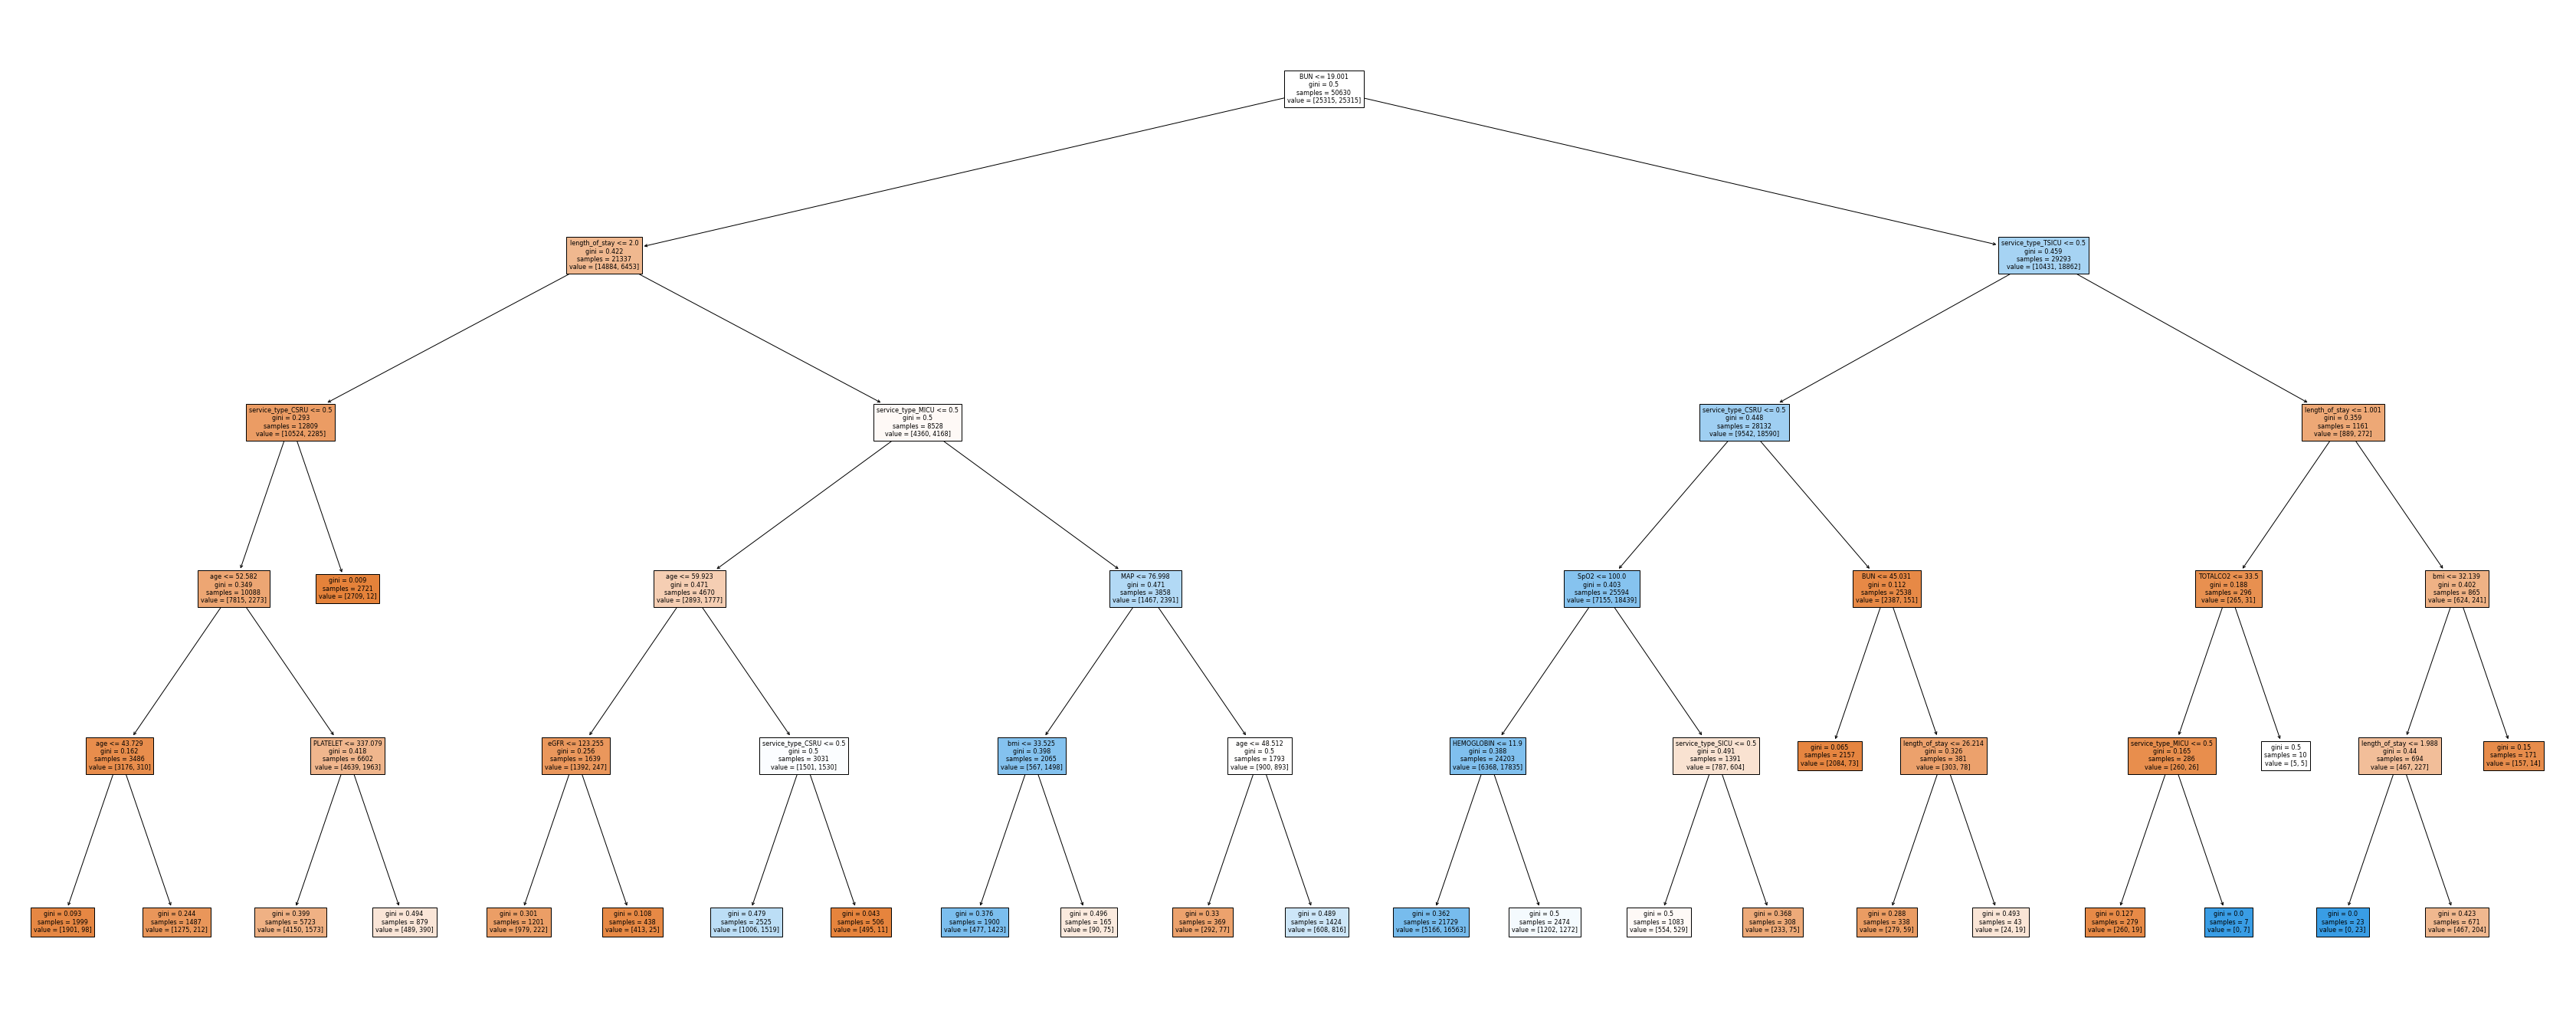

In [9]:
fig, ax = plt.subplots(figsize=(60, 24))
plot_tree(dtc_gs, feature_names=X_train.columns, filled=True, fontsize=8)

plt.savefig('tree_high_dpi', dpi=100)

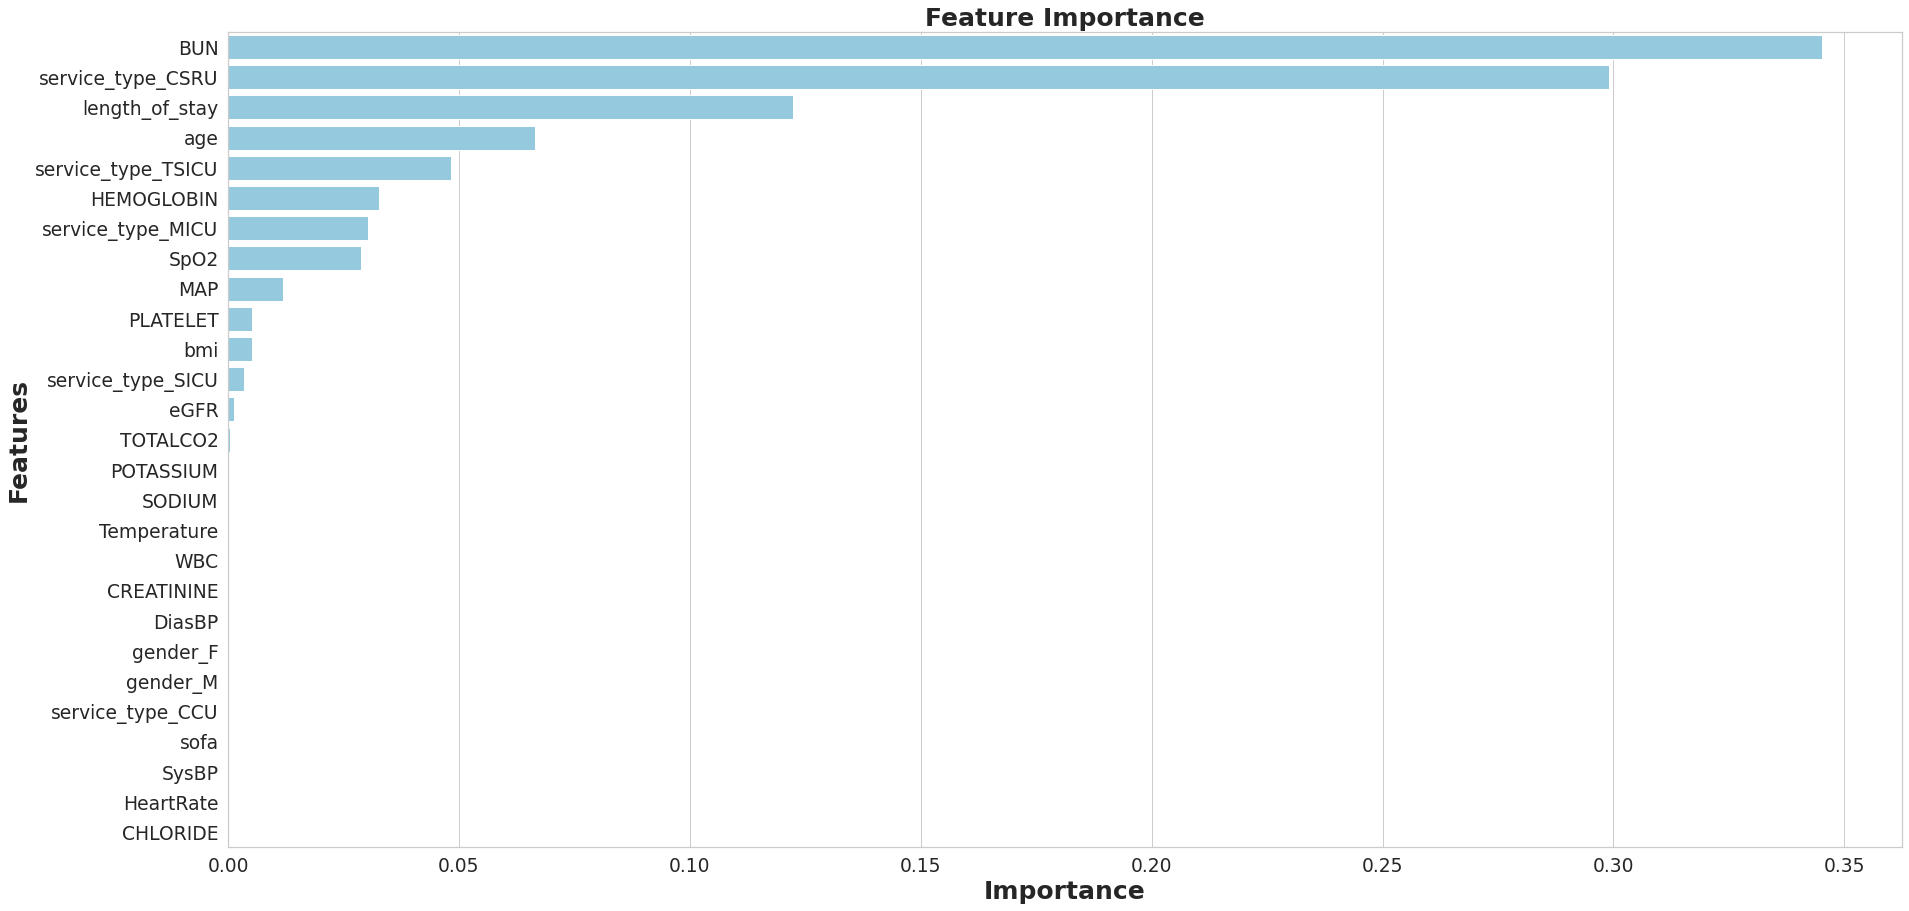

None

,Features,Gini-Importance
0,BUN,0.345237
1,service_type_CSRU,0.299027
2,length_of_stay,0.122296
3,age,0.066435
4,service_type_TSICU,0.048332
5,HEMOGLOBIN,0.032577
6,service_type_MICU,0.030224
7,SpO2,0.028712
8,MAP,0.011822
9,PLATELET,0.005175


In [10]:
feats = {}
for feature, importance in zip(X_train.columns, gs_dtc.best_estimator_.feature_importances_):
    feats[feature] = importance
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-Importance'})
importances = importances.sort_values(by='Gini-Importance', ascending=False)
importances = importances.reset_index()
importances = importances.rename(columns={'index': 'Features'})
sns.set(font_scale = 5)
sns.set(style="whitegrid", color_codes=True, font_scale = 1.7)
fig, ax = plt.subplots()
fig.set_size_inches(30,15)
sns.barplot(x=importances['Gini-Importance'], y=importances['Features'], data=importances, color='skyblue')
plt.xlabel('Importance', fontsize=25, weight = 'bold')
plt.ylabel('Features', fontsize=25, weight = 'bold')
plt.title('Feature Importance', fontsize=25, weight = 'bold')
display(plt.show())
display(importances)

In [11]:
n_nodes = gs_dtc.best_estimator_.tree_.node_count
children_left = gs_dtc.best_estimator_.tree_.children_left
children_right = gs_dtc.best_estimator_.tree_.children_right
feature = gs_dtc.best_estimator_.tree_.feature
threshold = gs_dtc.best_estimator_.tree_.threshold

def find_path(node_numb, path, x):
        path.append(node_numb)
        if node_numb == x:
            return True
        left = False
        right = False
        if (children_left[node_numb] !=-1):
            left = find_path(children_left[node_numb], path, x)
        if (children_right[node_numb] !=-1):
            right = find_path(children_right[node_numb], path, x)
        if left or right :
            return True
        path.remove(node_numb)
        return False

def get_rule(path, column_names):
    mask = ''
    for index, node in enumerate(path):
        #We check if we are not in the leaf
        if index!=len(path)-1:
            # Do we go under or over the threshold ?
            if (children_left[node] == path[index+1]):
                mask += "(df['{}']<= {}) \t ".format(column_names[feature[node]], threshold[node])
            else:
                mask += "(df['{}']> {}) \t ".format(column_names[feature[node]], threshold[node])
    # We insert the & at the right places
    mask = mask.replace("\t", "&", mask.count("\t") - 1)
    mask = mask.replace("\t", "")
    return mask

In [12]:
y_true_base, y_pred_base = y_test, dtc_gs.predict(X_test)
df = pd.DataFrame(y_pred_base, columns = ['prediction']).astype(int)
y = y_true_base.reset_index()
check = pd.concat([y, df], axis=1)
check.loc[(check["day_28_after_discharge_flag"]==1) & (check["prediction"]==1)].head(50)

,index,day_28_after_discharge_flag,prediction
29,69,1,1
31,35486,1,1
53,17213,1,1
55,929,1,1
68,32329,1,1
80,23293,1,1
135,35997,1,1
150,19474,1,1
180,35733,1,1
190,15305,1,1


In [13]:
# Leaves
leave_id = gs_dtc.best_estimator_.apply(X_test.iloc[[53]])

paths ={}
for leaf in np.unique(leave_id):
    path_leaf = []
    find_path(0, path_leaf, leaf)
    paths[leaf] = np.unique(np.sort(path_leaf))

rules = {}
for key in paths:
    rules[key] = get_rule(paths[key], X_train.columns)
    
print(rules)

{30: "(df['BUN']> 19.000672340393066) & (df['service_type_TSICU']<= 0.5) & (df['service_type_CSRU']<= 0.5) & (df['SpO2']<= 99.9998893737793) & (df['HEMOGLOBIN']<= 11.899868965148926)  "}


In [14]:
check.loc[(check["day_28_after_discharge_flag"]==1) & (check["prediction"]==0)].head(50)

,index,day_28_after_discharge_flag,prediction
3,9946,1,0
82,3132,1,0
106,31175,1,0
154,22921,1,0
274,31410,1,0
336,26824,1,0
361,22956,1,0
374,15814,1,0
436,30084,1,0
445,6187,1,0


In [15]:
# Leaves
leave_id = gs_dtc.best_estimator_.apply(X_test.iloc[[154]])

paths ={}
for leaf in np.unique(leave_id):
    path_leaf = []
    find_path(0, path_leaf, leaf)
    paths[leaf] = np.unique(np.sort(path_leaf))

rules = {}
for key in paths:
    rules[key] = get_rule(paths[key], X_train.columns)
    
print(rules)

{6: "(df['BUN']<= 19.000672340393066) & (df['length_of_stay']<= 2.0001391172409058) & (df['service_type_CSRU']<= 0.5) & (df['age']<= 52.582082748413086) & (df['age']> 43.72915267944336)  "}


In [16]:
check.loc[(check["day_28_after_discharge_flag"]==0) & (check["prediction"]==1)].head(50)

,index,day_28_after_discharge_flag,prediction
1,4873,0,1
2,16627,0,1
8,5177,0,1
12,36158,0,1
17,20694,0,1
23,21693,0,1
24,13598,0,1
25,35618,0,1
27,19491,0,1
36,29093,0,1


In [17]:
# Leaves
leave_id = gs_dtc.best_estimator_.apply(X_test.iloc[[17]])

paths ={}
for leaf in np.unique(leave_id):
    path_leaf = []
    find_path(0, path_leaf, leaf)
    paths[leaf] = np.unique(np.sort(path_leaf))

rules = {}
for key in paths:
    rules[key] = get_rule(paths[key], X_train.columns)
    
print(rules)

{30: "(df['BUN']> 19.000672340393066) & (df['service_type_TSICU']<= 0.5) & (df['service_type_CSRU']<= 0.5) & (df['SpO2']<= 99.9998893737793) & (df['HEMOGLOBIN']<= 11.899868965148926)  "}


In [18]:
check.loc[(check["day_28_after_discharge_flag"]==0) & (check["prediction"]==0)].head(50)

,index,day_28_after_discharge_flag,prediction
0,25130,0,0
4,8449,0,0
5,35021,0,0
6,21626,0,0
7,16561,0,0
9,15033,0,0
10,659,0,0
11,26542,0,0
13,26073,0,0
14,15994,0,0


In [20]:
# Leaves
leave_id = gs_dtc.best_estimator_.apply(X_test.iloc[[5]])

paths ={}
for leaf in np.unique(leave_id):
    path_leaf = []
    find_path(0, path_leaf, leaf)
    paths[leaf] = np.unique(np.sort(path_leaf))

rules = {}
for key in paths:
    rules[key] = get_rule(paths[key], X_train.columns)
    
print(rules)

{10: "(df['BUN']<= 19.000672340393066) & (df['length_of_stay']<= 2.0001391172409058) & (df['service_type_CSRU']> 0.5)  "}


In [16]:
df_dtc_positive_positive = check.loc[(check["day_28_after_discharge_flag"]==1) & (check["prediction"]==1)]

In [17]:
df_dtc_positive_negative = check.loc[(check["day_28_after_discharge_flag"]==1) & (check["prediction"]==0)]

In [18]:
df_dtc_negative_positive = check.loc[(check["day_28_after_discharge_flag"]==0) & (check["prediction"]==1)]

In [19]:
df_dtc_negative_negative = check.loc[(check["day_28_after_discharge_flag"]==0) & (check["prediction"]==0)]

## Random Forest

In [63]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split
import sklearn.metrics as metrics
from sklearn.metrics import classification_report, recall_score, confusion_matrix, roc_curve, auc
from statistics import mean, stdev
import sklearn.metrics as metrics
from sklearn.model_selection import GridSearchCV

oversample = SMOTENC(categorical_features=[20, 21, 22, 23, 24])
n_estimators = [200]
max_features = ['sqrt']
max_depth = [int(x) for x in np.linspace(start = 2, stop = 5, num = 4)]
min_samples_split = [27,28,29]
min_samples_leaf = [2,3,4]
bootstrap = [False]

param_dist = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# Preprocessing
numerical_train_x = train_x[numerical_cols].reset_index(drop=True)
categorical_train_x = pd.get_dummies(train_x[[var for var in categorical_cols]]).reset_index(drop=True)
X_train = pd.concat([numerical_train_x, categorical_train_x],axis=1)
numerical_test_x = test_x[numerical_cols].reset_index(drop=True)
categorical_test_x = pd.get_dummies(test_x[[var for var in categorical_cols]]).reset_index(drop=True)
X_test = pd.concat([numerical_test_x, categorical_test_x],axis=1)

# Modelling
X, y = oversample.fit_resample(X_train, y_train)

rfc = RandomForestClassifier()
gs_rfc = GridSearchCV(rfc, param_dist, cv = 5, verbose = 1, n_jobs=-1)
gs_rfc.fit(X, y)
print(gs_rfc.best_params_)
rfc_gs = gs_rfc.best_estimator_.fit(X, y)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  1.7min finished


{'bootstrap': False, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 28, 'n_estimators': 200}


In [64]:
import shap

explainer = shap.TreeExplainer(rfc_gs)
y_true_base, y_pred_base = y_test, rfc_gs.predict(X_test)
df = pd.DataFrame(y_pred_base, columns = ['prediction']).astype(int)
y = y_true_base.reset_index()
check = pd.concat([y, df], axis=1)
check.loc[(check["day_28_after_discharge_flag"]==1) & (check["prediction"]==1)].head(50)

,index,day_28_after_discharge_flag,prediction
29,69,1,1
53,17213,1,1
68,32329,1,1
80,23293,1,1
135,35997,1,1
150,19474,1,1
200,14192,1,1
205,35211,1,1
212,13474,1,1
236,14323,1,1


In [65]:
choosen_instance = X_test.loc[[53]]
shap_values = explainer.shap_values(choosen_instance)
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], choosen_instance)

In [66]:
check.loc[(check["day_28_after_discharge_flag"]==1) & (check["prediction"]==0)].head(50)

,index,day_28_after_discharge_flag,prediction
3,9946,1,0
31,35486,1,0
55,929,1,0
82,3132,1,0
106,31175,1,0
154,22921,1,0
180,35733,1,0
190,15305,1,0
243,9157,1,0
244,29882,1,0


In [67]:
choosen_instance = X_test.loc[[154]]
shap_values = explainer.shap_values(choosen_instance)
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], choosen_instance)

In [68]:
check.loc[(check["day_28_after_discharge_flag"]==0) & (check["prediction"]==1)].head(50)

,index,day_28_after_discharge_flag,prediction
2,16627,0,1
17,20694,0,1
23,21693,0,1
24,13598,0,1
32,27928,0,1
36,29093,0,1
43,21702,0,1
48,17455,0,1
57,17991,0,1
58,27995,0,1


In [69]:
choosen_instance = X_test.loc[[17]]
shap_values = explainer.shap_values(choosen_instance)
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0], choosen_instance)

In [70]:
check.loc[(check["day_28_after_discharge_flag"]==0) & (check["prediction"]==0)].head(50)

,index,day_28_after_discharge_flag,prediction
0,25130,0,0
1,4873,0,0
4,8449,0,0
5,35021,0,0
6,21626,0,0
7,16561,0,0
8,5177,0,0
9,15033,0,0
10,659,0,0
11,26542,0,0


In [71]:
choosen_instance = X_test.loc[[5]]
shap_values = explainer.shap_values(choosen_instance)
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0], choosen_instance)

In [22]:
df_rfc_positive_positive = check.loc[(check["day_28_after_discharge_flag"]==1) & (check["prediction"]==1)]

In [23]:
df_rfc_positive_negative = check.loc[(check["day_28_after_discharge_flag"]==1) & (check["prediction"]==0)]

In [24]:
df_rfc_negative_positive = check.loc[(check["day_28_after_discharge_flag"]==0) & (check["prediction"]==1)]

In [25]:
df_rfc_negative_negative = check.loc[(check["day_28_after_discharge_flag"]==0) & (check["prediction"]==0)]

## K Nearest Neighbours

In [128]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import time
import sklearn.metrics as metrics
from sklearn.metrics import classification_report
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from statistics import mean
from statistics import stdev 

oversample = SMOTENC(categorical_features=[20, 21, 22, 23, 24])
n = [int(x) for x in np.linspace(start = 16, stop = 25, num = 10)]
param_dist = {'n_neighbors': n}

# Standardisation
scale_numerical_cols = df_features[numerical_cols].columns
scaler = StandardScaler().fit(train_x[numerical_cols])
numerical_train_x = pd.DataFrame(scaler.transform(train_x[numerical_cols]),columns=scale_numerical_cols)
categorical_train_x = pd.get_dummies(train_x[[var for var in categorical_cols]], drop_first = True).reset_index(drop=True)
X_train = pd.concat([numerical_train_x, categorical_train_x],axis=1)
numerical_test_x = pd.DataFrame(scaler.transform(test_x[numerical_cols]),columns=scale_numerical_cols)
categorical_test_x = pd.get_dummies(test_x[[var for var in categorical_cols]], drop_first = True).reset_index(drop=True)
X_test = pd.concat([numerical_test_x, categorical_test_x],axis=1)

# Modelling
X, y = oversample.fit_resample(X_train, y_train)

knc = KNeighborsClassifier()
gs_knc = GridSearchCV(knc, param_dist, cv = 5, verbose = 1, n_jobs=-1)
gs_knc.fit(X, y)
print(gs_knc.best_params_)
knc_gs = gs_knc.best_estimator_.fit(X, y)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   52.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  2.5min finished


{'n_neighbors': 16}


In [129]:
X

,age,length_of_stay,sofa,DiasBP,HeartRate,MAP,SpO2,SysBP,Temperature,BUN,CHLORIDE,CREATININE,HEMOGLOBIN,PLATELET,POTASSIUM,SODIUM,TOTALCO2,WBC,bmi,eGFR,gender_M,service_type_CSRU,service_type_MICU,service_type_SICU,service_type_TSICU
0,-2.170207,0.491205,-0.373683,1.118218,1.306914,1.081815,1.446669,0.509977,2.391747,-0.598541,-0.920487,-0.981659,-0.144233,1.164337,1.442733,0.593438,1.901961,-0.337388,0.507271,3.140861,1,0,1,0,0
1,1.438639,-0.450194,0.295025,-0.954824,-0.319489,-0.582674,-0.269394,-0.182033,-0.548941,-0.598541,0.481509,-0.379254,0.668143,0.028597,1.657700,0.079700,-0.215394,1.484654,0.164440,0.061252,1,1,0,0,0
2,0.567645,-0.293294,0.629379,-1.053540,0.005791,-0.941685,1.446669,-0.748223,0.406515,0.106343,-1.120772,-0.258773,0.378008,-1.588698,1.442733,-1.204647,-0.450656,0.552447,0.008856,-0.450604,0,1,0,0,0
3,-1.011341,-0.450194,0.295025,0.427204,0.258787,0.396437,1.446669,-0.213488,1.330130,-1.303425,1.683219,-0.861178,-0.260287,0.119456,-3.071574,0.336569,-1.156441,1.251602,-0.318921,1.387194,0,0,1,0,0
4,-0.094828,-0.136394,0.629379,-0.658675,-0.464058,-0.060485,-1.413435,0.132517,1.595535,-0.214059,-1.321057,-0.258773,-0.782529,-0.371184,-0.921904,-1.204647,0.960914,-0.909424,1.300788,0.391503,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50625,0.652698,-0.422554,-0.314783,-1.175788,-1.253011,-1.152893,0.302627,-1.096020,-1.046424,-0.417924,1.718502,-0.655800,0.504284,-0.754911,0.140684,-0.631022,-0.810250,-1.269928,0.615727,0.730571,1,0,0,0,0
50626,1.028840,2.941144,0.732137,-1.000332,-0.344524,-0.884044,-0.269394,-0.840427,0.667980,0.924542,-1.182326,-0.138292,-0.130791,-0.188778,0.384665,-0.038718,1.829657,1.118317,-0.425289,-0.316949,1,0,0,0,0
50627,1.342342,-0.056889,-0.369186,-0.683686,0.507894,-1.330070,-0.696486,-1.550114,0.493568,1.421283,-1.969963,1.100284,0.251155,-0.046413,0.098467,-1.269728,0.898144,-0.660269,-0.011607,-1.472157,1,0,0,0,0
50628,-0.060860,0.102596,0.724605,0.796559,-0.273053,0.942386,0.874648,0.132917,-0.229268,0.115672,-0.720202,0.188837,0.278481,-0.077731,0.470394,1.180335,1.912879,0.200142,1.570849,-0.647975,1,0,0,0,0


In [130]:
y

0        0
1        0
2        0
3        0
4        0
        ..
50625    1
50626    1
50627    1
50628    1
50629    1
Name: day_28_after_discharge_flag, Length: 50630, dtype: int64

In [131]:
y_true_base, y_pred_base = y_test, knc_gs.predict(X_test)
df = pd.DataFrame(y_pred_base, columns = ['prediction']).astype(int)
test_y = y_true_base.reset_index()
check = pd.concat([test_y, df], axis=1)
check

,index,day_28_after_discharge_flag,prediction
0,25130,0,0
1,4873,0,1
2,16627,0,0
3,9946,1,0
4,8449,0,0
...,...,...,...
9078,16583,0,0
9079,33245,1,1
9080,26619,0,0
9081,9357,0,0


In [132]:
check.loc[(check["day_28_after_discharge_flag"]==1) & (check["prediction"]==1)].head(50)

,index,day_28_after_discharge_flag,prediction
29,69,1,1
31,35486,1,1
53,17213,1,1
55,929,1,1
68,32329,1,1
106,31175,1,1
150,19474,1,1
154,22921,1,1
180,35733,1,1
190,15305,1,1


In [133]:
knc_gs.kneighbors(X_test.loc[[53]], return_distance=True, n_neighbors=16)

(array([[2.90010503, 2.93506698, 2.98929052, 2.99277189, 3.03807585,
         3.05368654, 3.05414765, 3.11907861, 3.13230831, 3.13719548,
         3.14805304, 3.15615943, 3.15853538, 3.15962525, 3.16781717,
         3.17586332]]),
 array([[47978, 30510, 40361, 31978, 42673, 40030, 31359, 50000, 28009,
         31615, 27975,  9514, 46904, 50587, 42169, 21494]]))

In [139]:
X_test.loc[[53]]

,age,length_of_stay,sofa,DiasBP,HeartRate,MAP,SpO2,SysBP,Temperature,BUN,CHLORIDE,CREATININE,HEMOGLOBIN,PLATELET,POTASSIUM,SODIUM,TOTALCO2,WBC,bmi,eGFR,gender_M,service_type_CSRU,service_type_MICU,service_type_SICU,service_type_TSICU
53,0.660526,-0.136394,0.963733,-0.954824,1.740621,-1.561785,-0.841414,-1.251503,-0.846195,0.362664,-2.522767,1.548442,-1.30477,0.419291,-0.062036,-1.461516,1.196176,-0.464507,0.732657,-1.799145,0,0,0,0,0


In [142]:
scaler.inverse_transform(X_test.loc[[53]].iloc[:, 0:20])

array([[ 73.7       ,   3.        ,   7.        ,  51.        ,
        108.        ,  62.        ,  96.        , 100.        ,
         36.44444444,  28.        ,  92.        ,   2.4       ,
          8.3       , 266.        ,   4.        , 133.        ,
         31.        ,   8.3       ,  32.69629522,  19.28300189]])

In [138]:
X.loc[[47978, 30510, 40361, 31978, 42673, 40030, 31359, 50000, 28009,
         31615, 27975,  9514, 46904, 50587, 42169, 21494]]

,age,length_of_stay,sofa,DiasBP,HeartRate,MAP,SpO2,SysBP,Temperature,BUN,CHLORIDE,CREATININE,HEMOGLOBIN,PLATELET,POTASSIUM,SODIUM,TOTALCO2,WBC,bmi,eGFR,gender_M,service_type_CSRU,service_type_MICU,service_type_SICU,service_type_TSICU
47978,1.152401,-0.227716,-0.124213,-0.716132,1.179576,-1.315543,-0.841414,-1.895599,-0.362053,0.279540,-1.772474,0.895681,-0.636113,0.995838,-0.472668,-0.756121,1.059244,-0.207777,-0.360081,-1.381205,1,0,1,0,0
30510,0.629847,0.100917,0.050528,-0.360058,1.292909,-0.897826,0.023767,-1.375750,-0.140481,1.420791,-2.576594,1.190011,-0.554773,-0.936499,0.640638,-1.593162,1.374093,-0.724439,0.430554,-1.462779,1,0,0,0,0
40361,0.530861,0.037141,0.494294,-0.455018,1.408403,-0.909792,-0.038288,-1.295666,-0.250288,1.585698,-2.364953,1.271578,-0.741793,-0.973826,1.246241,-1.412206,1.571650,-0.733619,0.668009,-1.491691,1,0,0,0,0
31978,0.512575,0.049362,0.476932,-0.438358,1.412156,-0.898352,-0.008584,-1.297300,-0.259659,1.574052,-2.396154,1.274706,-0.740287,-1.000483,1.207171,-1.438884,1.559433,-0.734169,0.661606,-1.491133,1,0,0,0,0
42673,0.983917,-0.263030,0.101545,-0.738350,1.325997,-1.333908,-0.841414,-2.023031,-0.708513,-0.124290,-1.637240,0.922798,-0.871194,1.331212,-0.714580,-0.582681,1.006294,-0.026577,-0.469100,-1.376674,1,0,1,0,0
40030,0.694871,-0.072470,0.650016,-0.604440,1.374737,-1.012394,-0.304700,-1.281017,-0.166234,1.690155,-2.085111,1.243521,-0.755306,-0.734737,1.596655,-1.172938,1.681220,-0.728685,0.725440,-1.496689,1,0,0,0,0
31359,0.363149,0.194586,0.404858,-0.296238,1.411908,-0.778496,0.302627,-1.286859,-0.562440,1.592364,-2.744983,1.228325,-0.737210,-1.196206,0.562447,-1.718386,1.405677,-0.728333,0.796807,-1.479731,1,0,0,0,0
50000,0.465710,-0.420513,0.295025,-0.757391,1.773841,-1.515040,-0.609509,-2.285271,-0.747199,-0.262547,-1.277746,0.555278,-1.260863,0.922438,-0.398998,-0.850594,0.770157,-0.008713,-0.724520,-0.901104,1,0,0,0,0
28009,0.273646,0.245821,0.513715,-0.349899,1.073251,-0.863884,0.177914,-1.341845,-0.302298,1.493943,-2.766719,1.465085,-0.281711,-1.139130,0.704097,-1.830392,1.277561,-0.592119,0.552846,-1.531141,1,0,0,0,0
31615,0.893643,-0.030344,-0.125236,-0.964191,0.997199,-1.520573,-0.841414,-1.868664,-0.938718,0.039736,-1.773087,0.542206,-0.805231,1.732838,-0.741771,-1.079774,0.566637,0.226360,-0.730078,-1.189304,0,0,0,0,0


In [135]:
example53 = scaler.inverse_transform(X.loc[[47978, 30510, 40361, 31978, 42673, 40030, 31359, 50000, 28009,
         31615, 27975,  9514, 46904, 50587, 42169, 21494]].iloc[:, 0:20])
example53 = pd.DataFrame(data = example53, columns = df_features[numerical_cols].columns)
example53

,age,length_of_stay,sofa,DiasBP,HeartRate,MAP,SpO2,SysBP,Temperature,BUN,CHLORIDE,CREATININE,HEMOGLOBIN,PLATELET,POTASSIUM,SODIUM,TOTALCO2,WBC,bmi,eGFR
0,81.696547,2.417958,3.746126,53.417958,100.238379,64.514955,96.000000,89.761621,36.697800,26.702821,95.746126,1.858204,9.452324,329.454908,3.808979,135.746126,30.417958,9.511760,25.784296,33.077750
1,73.201248,4.512500,4.268750,57.025000,101.806251,68.781251,97.512500,98.025000,36.813751,44.512500,91.731250,2.102500,9.592500,116.781232,4.326875,132.487500,31.756250,7.073125,30.785378,30.385272
2,71.592005,4.106025,5.595983,56.063054,103.404017,68.659037,97.404017,99.297992,36.756288,47.085942,92.787950,2.170201,9.270201,112.673067,4.608594,133.191967,32.595983,7.029799,32.287376,29.431004
3,71.294714,4.183918,5.544055,56.231822,103.455945,68.775877,97.455945,99.272027,36.751384,46.904192,92.632165,2.172797,9.272797,109.739099,4.590419,133.088110,32.544055,7.027203,32.246872,29.449397
4,78.957457,2.192889,4.421333,53.192889,102.264000,64.327393,96.000000,87.736000,36.516494,20.400887,96.421333,1.880711,9.047200,366.366231,3.696444,136.421333,30.192889,10.367022,25.094712,33.227304
5,74.258356,3.407418,6.061722,54.549405,102.938278,67.611126,96.938278,99.530861,36.800274,48.716025,94.185165,2.146914,9.246914,138.987269,4.771603,134.123443,33.061722,7.053086,32.650649,29.266036
6,68.865459,5.109498,5.328495,57.671505,103.452509,70.000000,98.000000,99.437993,36.592936,47.189964,90.890502,2.134301,9.278100,88.197848,4.290502,132.000000,31.890502,7.054749,33.102069,29.825750
7,70.532826,1.189170,5.000000,53.000000,108.459567,62.477426,96.405415,83.567509,36.496250,18.243322,98.216246,1.575668,8.375668,321.376529,3.843249,135.378339,29.189170,10.451336,23.479075,48.924235
8,67.410380,5.436045,5.654068,57.127910,98.767459,69.127910,97.781977,98.563955,36.729070,45.654068,90.781977,2.330814,10.063079,94.479601,4.356395,131.563955,31.345932,7.697672,31.558920,28.128881
9,77.489853,3.675911,3.743067,50.905112,97.715335,62.420916,96.000000,90.189777,36.396026,22.960576,95.743067,1.564818,9.160875,410.569330,3.683796,134.486134,28.324089,11.560875,23.443919,39.411749


In [136]:
example53.describe().T

,count,mean,std,min,25%,50%,75%,max
age,16.0,73.774668,5.566284,62.610000,70.115984,73.729802,79.099157,81.696547
length_of_stay,16.0,3.964311,1.387949,1.189170,3.160053,4.144971,5.111133,5.701073
sofa,16.0,5.792100,1.680102,3.743067,4.855333,5.570019,6.015430,9.114899
DiasBP,16.0,53.535689,3.380383,45.000000,50.900586,53.305423,56.413907,57.671505
HeartRate,16.0,99.336071,5.899922,84.000000,96.947531,101.022315,103.416140,108.459567
MAP,16.0,65.875873,3.407926,57.000000,64.287207,65.743468,68.777220,70.000000
SpO2,16.0,96.827386,0.843545,96.000000,96.000000,96.671847,97.569385,98.000000
SysBP,16.0,96.307692,6.585136,83.567509,90.082738,98.917991,99.648146,104.229798
Temperature,16.0,36.655777,0.179790,36.333334,36.511433,36.731866,36.803643,36.843482
BUN,16.0,37.413753,13.915195,15.000000,22.320654,45.716972,47.571479,50.365360


In [137]:
y.loc[y.index.isin([49194, 33721, 27728, 32412, 32378, 48871, 39595, 32779, 42849,
         36718, 38872, 43704, 38135,  9514, 48549, 47544])]

9514     0
27728    1
32378    1
32412    1
32779    1
33721    1
36718    1
38135    1
38872    1
39595    1
42849    1
43704    1
47544    1
48549    1
48871    1
49194    1
Name: day_28_after_discharge_flag, dtype: int64

In [39]:
scaler.inverse_transform(X.loc[[32586]].iloc[:, 0:20])

array([[ 78.03579347,   4.04312685,   3.56469027,  56.0862537 ,
         99.69407082,  67.60781712,  97.04312685,  97.0862537 ,
         36.92327121,  44.04312685,  92.43530973,   2.00862537,
          9.87412389, 153.15766929,   4.25646903, 132.95687315,
         31.52156342,   7.14353097,  29.78680655,  31.10080537]])

In [40]:
scaler.inverse_transform(X.loc[[47933]].iloc[:, 0:20])

array([[ 71.45166005,   4.14279649,   5.571469  ,  56.14272574,
        103.428531  ,  68.71419474,  97.428531  ,  99.2857345 ,
         36.75397262,  47.00014151,  92.71440701,   2.17142655,
          9.27142655, 111.28799874,   4.60001415, 133.14293801,
         32.571469  ,   7.02857345,  32.2682545 ,  29.43968696]])

In [31]:
check.loc[(check["day_28_after_discharge_flag"]==1) & (check["prediction"]==0)].head(50)

,index,day_28_after_discharge_flag,prediction
3,9946,1,0
80,23293,1,0
82,3132,1,0
135,35997,1,0
180,35733,1,0
205,35211,1,0
236,14323,1,0
374,15814,1,0
436,30084,1,0
443,32394,1,0


In [32]:
knc_gs.kneighbors(X_test.loc[[154]], return_distance=True, n_neighbors=16)

(array([[2.229547  , 2.2462253 , 2.24684368, 2.2478199 , 2.25094269,
         2.36070803, 2.3969756 , 2.41685058, 2.47358316, 2.47903425,
         2.48556377, 2.5085419 , 2.55082607, 2.56038231, 2.56587847,
         2.58002479]]),
 array([[37937, 40175, 38609, 43185, 32304, 33420, 38603, 50330, 28983,
         32662, 38394, 22489,  4520, 31528, 41138, 40279]]))

In [41]:
scaler.inverse_transform(X.loc[[37937]].iloc[:, 0:20])

array([[ 60.49282805,   3.06009948,   1.30049741,  68.66109431,
         79.3822881 ,  89.48079586,  95.18029845, 126.60099483,
         37.68669943,  19.87980103,  97.93990052,   0.71802984,
         12.21802984, 183.72119379,   4.2       , 131.06009948,
         24.12019897,  11.45576124,  33.6392939 , 100.88240184]])

In [42]:
scaler.inverse_transform(X.loc[[40175]].iloc[:, 0:20])

array([[ 61.1819329 ,   3.56629388,   1.        ,  67.15055918,
         79.69888163,  89.28314694,  95.84944082, 131.94608571,
         37.79250921,  21.69888163,  99.69888163,   0.75662939,
         11.49213265, 197.15734693,   4.22831469, 132.13258775,
         24.        ,  12.27955265,  32.77564585,  98.90334985]])

In [42]:
check.loc[(check["day_28_after_discharge_flag"]==0) & (check["prediction"]==1)].head(50)

,index,day_28_after_discharge_flag,prediction
2,16627,0,1
17,20694,0,1
23,21693,0,1
24,13598,0,1
32,27928,0,1
36,29093,0,1
43,21702,0,1
48,17455,0,1
57,17991,0,1
58,27995,0,1


In [43]:
knc_gs.kneighbors(X_test.loc[[17]], return_distance=True, n_neighbors=16)

(array([[2.57083816, 2.7658113 , 2.87204845, 2.97104771, 2.97179356,
         3.03341042, 3.03796219, 3.04166435, 3.0513655 , 3.06394336,
         3.08769733, 3.13973942, 3.14019996, 3.17716335, 3.19219687,
         3.19869818]]),
 array([[33684, 37440, 10061,  8879, 33647, 37147, 19500, 41738, 42580,
         45248, 29502, 43016, 41888, 38910, 27522, 35857]]))

In [84]:
X.loc[[33684]]

,age,length_of_stay,sofa,DiasBP,HeartRate,MAP,SpO2,SysBP,Temperature,BUN,CHLORIDE,CREATININE,HEMOGLOBIN,PLATELET,POTASSIUM,SODIUM,TOTALCO2,WBC,bmi,eGFR,gender_M,service_type_CSRU,service_type_MICU,service_type_SICU,service_type_TSICU
33684,-0.492048,1.404512,0.195249,1.169801,-0.101006,0.598103,-0.269394,0.092135,1.473532,0.825589,-0.343538,-0.287536,0.781581,2.89011,0.570036,0.804316,0.061991,0.761138,-0.667979,0.564286,1,0,0,1,0


In [44]:
scaler.inverse_transform(X.loc[[33684]].iloc[:, 0:20])

array([[ 65.05975268,   5.08954753,   8.77238688,  50.08954753,
         78.50374429,  77.94122458,  98.        , 130.80315899,
         36.69195663,  64.79290162, 113.22761312,   1.48414197,
          9.7475741 , 265.77238688,   3.82276131, 147.22761312,
         27.45522623,  11.57163803,  36.41708449,  37.02491214]])

In [85]:
X.loc[[37440]]

,age,length_of_stay,sofa,DiasBP,HeartRate,MAP,SpO2,SysBP,Temperature,BUN,CHLORIDE,CREATININE,HEMOGLOBIN,PLATELET,POTASSIUM,SODIUM,TOTALCO2,WBC,bmi,eGFR,gender_M,service_type_CSRU,service_type_MICU,service_type_SICU,service_type_TSICU
37440,0.316374,-0.342437,0.037214,0.418884,1.47149,0.110956,-1.151531,-0.165373,0.412395,2.275806,-0.423423,4.512576,-0.309921,0.226417,0.896257,-1.520321,-2.063458,0.945797,0.650076,-2.037346,1,0,0,0,0


In [45]:
scaler.inverse_transform(X.loc[[37440]].iloc[:, 0:20])

array([[ 67.0046906 ,   7.00338559,   9.2508464 ,  52.00338559,
         73.24068964,  80.69236678,  98.        , 135.94659876,
         36.63879527,  68.38134797, 112.7491536 ,   1.41237304,
          9.96288088, 266.2508464 ,   3.77491536, 146.7491536 ,
         26.49830721,  13.10270847,  37.28486401,  38.77576062]])

In [47]:
check.loc[(check["day_28_after_discharge_flag"]==0) & (check["prediction"]==0)].head(50)

,index,day_28_after_discharge_flag,prediction
0,25130,0,0
2,16627,0,0
4,8449,0,0
5,35021,0,0
6,21626,0,0
7,16561,0,0
8,5177,0,0
9,15033,0,0
10,659,0,0
11,26542,0,0


In [48]:
knc_gs.kneighbors(X_test.loc[[5]], return_distance=True, n_neighbors=16)

(array([[1.93823284, 1.96766161, 2.37766987, 2.41812362, 2.50653545,
         2.52750633, 2.53681932, 2.56469608, 2.68585781, 2.68672117,
         2.70374667, 2.71232098, 2.78581683, 2.80025751, 2.8421491 ,
         2.8426737 ]]),
 array([[  962, 23921,   776, 14887, 17949,  9798,  6649, 25697,  1843,
         11951,   142, 25550,  6526,  3052, 20970, 13883]]))

In [86]:
X.loc[[962]]

,age,length_of_stay,sofa,DiasBP,HeartRate,MAP,SpO2,SysBP,Temperature,BUN,CHLORIDE,CREATININE,HEMOGLOBIN,PLATELET,POTASSIUM,SODIUM,TOTALCO2,WBC,bmi,eGFR,gender_M,service_type_CSRU,service_type_MICU,service_type_SICU,service_type_TSICU
962,-1.14728,-0.450194,-0.039329,0.377846,0.439499,-0.044163,1.446669,-0.936953,-0.315386,-0.854863,0.080939,-0.258773,-0.550421,-0.107692,1.6577,-0.947778,-0.450656,0.277022,1.315343,-0.032472,0,1,0,0,0


In [50]:
scaler.inverse_transform(X.loc[[962]].iloc[:, 0:20])

array([[ 44.31      ,   1.        ,   4.        ,  64.5       ,
         90.        ,  77.5       , 100.        , 105.        ,
         36.72222137,   9.        , 105.        ,   0.9       ,
          9.6       , 208.        ,   4.8       , 135.        ,
         24.        ,  11.8       ,  36.38201721,  77.59476603]])

In [87]:
X.loc[[23921]]

,age,length_of_stay,sofa,DiasBP,HeartRate,MAP,SpO2,SysBP,Temperature,BUN,CHLORIDE,CREATININE,HEMOGLOBIN,PLATELET,POTASSIUM,SODIUM,TOTALCO2,WBC,bmi,eGFR,gender_M,service_type_CSRU,service_type_MICU,service_type_SICU,service_type_TSICU
23921,-0.232613,-0.450194,0.295025,-0.362526,-0.138778,-0.386852,0.874648,-0.559493,0.215426,-0.149979,0.481509,-0.017811,0.029847,-0.82548,2.302601,-0.17717,-0.685917,0.446514,1.57627,-0.171739,1,1,0,0,0


In [51]:
scaler.inverse_transform(X.loc[[23921]].iloc[:, 0:20])

array([[ 59.18      ,   1.        ,   5.        ,  57.        ,
         82.        ,  74.        ,  99.        , 111.        ,
         37.        ,  20.        , 107.        ,   1.1       ,
         10.6       , 129.        ,   5.1       , 138.        ,
         23.        ,  12.6       ,  38.03248256,  72.99801928]])

In [28]:
df_knn_positive_positive = check.loc[(check["day_28_after_discharge_flag"]==1) & (check["prediction"]==1)]

In [29]:
df_knn_positive_negative = check.loc[(check["day_28_after_discharge_flag"]==1) & (check["prediction"]==0)]

In [30]:
df_knn_negative_positive = check.loc[(check["day_28_after_discharge_flag"]==0) & (check["prediction"]==1)]

In [31]:
df_knn_negative_negative = check.loc[(check["day_28_after_discharge_flag"]==0) & (check["prediction"]==0)]

# Multi-Layered Perceptron

In [74]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import time
import sklearn.metrics as metrics
from sklearn.metrics import classification_report, recall_score, confusion_matrix
from statistics import mean, stdev 
from sklearn.model_selection import GridSearchCV
import shap

oversample = SMOTENC(categorical_features=[20, 21, 22, 23, 24])
activation = ['tanh', 'relu','logistic']
alpha = [float(x) for x in np.geomspace(start = 0.00001, stop = 0.01, num = 4)]
hidden_layer_sizes = [(15, 15), (16, 16), (17, 17), (18, 18), (19, 19)]

parameter_space = {
    'activation': activation,
    'alpha': alpha,
    'hidden_layer_sizes': hidden_layer_sizes}

# Standardisation
scale_numerical_cols = df_features[numerical_cols].columns
scaler = StandardScaler().fit(train_x[numerical_cols])
numerical_train_x = pd.DataFrame(scaler.transform(train_x[numerical_cols]),columns=scale_numerical_cols)
categorical_train_x = pd.get_dummies(train_x[[var for var in categorical_cols]], drop_first = True).reset_index(drop=True)
X_train = pd.concat([numerical_train_x, categorical_train_x],axis=1)
numerical_test_x = pd.DataFrame(scaler.transform(test_x[numerical_cols]),columns=scale_numerical_cols)
categorical_test_x = pd.get_dummies(test_x[[var for var in categorical_cols]], drop_first = True).reset_index(drop=True)
X_test = pd.concat([numerical_test_x, categorical_test_x],axis=1)

# Modelling
X, y = oversample.fit_resample(X_train, y_train)

mlp = MLPClassifier()
gs_mlp = GridSearchCV(mlp, parameter_space, cv = 5, verbose = 1, n_jobs=-1)
gs_mlp.fit(X, y)
print(gs_mlp.best_params_)
mlp_gs = gs_mlp.best_estimator_.fit(X, y)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   42.4s
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 10.2min finished
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


{'activation': 'tanh', 'alpha': 0.001, 'hidden_layer_sizes': (19, 19)}


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


In [76]:
import shap

y_true_base, y_pred_base = y_test, mlp_gs.predict(X_test)
df = pd.DataFrame(y_pred_base, columns = ['prediction']).astype(int)
y = y_true_base.reset_index()
check = pd.concat([y, df], axis=1)
check.loc[(check["day_28_after_discharge_flag"]==1) & (check["prediction"]==1)].head(50)

,index,day_28_after_discharge_flag,prediction
29,69,1,1
53,17213,1,1
55,929,1,1
68,32329,1,1
154,22921,1,1
180,35733,1,1
190,15305,1,1
200,14192,1,1
205,35211,1,1
212,13474,1,1


In [77]:
choosen_instance = X_test.loc[[53]]
background = X.loc[np.random.choice(X.shape[0], 500, replace=False)]
explainer = shap.KernelExplainer(mlp_gs.predict_proba, background)
shap_values = explainer.shap_values(choosen_instance)
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], choosen_instance)

Using 500 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [78]:
check.loc[(check["day_28_after_discharge_flag"]==1) & (check["prediction"]==0)].head(50)

,index,day_28_after_discharge_flag,prediction
3,9946,1,0
31,35486,1,0
80,23293,1,0
82,3132,1,0
106,31175,1,0
135,35997,1,0
150,19474,1,0
236,14323,1,0
243,9157,1,0
244,29882,1,0


In [79]:
choosen_instance = X_test.loc[[154]]
background = X.loc[np.random.choice(X.shape[0], 500, replace=False)]
explainer = shap.KernelExplainer(mlp_gs.predict_proba, background)
shap_values = explainer.shap_values(choosen_instance)
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], choosen_instance)

Using 500 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [80]:
import shap

y_true_base, y_pred_base = y_test, mlp_gs.predict(X_test)
df = pd.DataFrame(y_pred_base, columns = ['prediction']).astype(int)
y = y_true_base.reset_index()
check = pd.concat([y, df], axis=1)
check.loc[(check["day_28_after_discharge_flag"]==0) & (check["prediction"]==1)].head(50)

,index,day_28_after_discharge_flag,prediction
17,20694,0,1
23,21693,0,1
24,13598,0,1
25,35618,0,1
43,21702,0,1
48,17455,0,1
58,27995,0,1
70,2361,0,1
87,34777,0,1
96,36302,0,1


In [81]:
choosen_instance = X_test.loc[[17]]
background = X.loc[np.random.choice(X.shape[0], 500, replace=False)]
explainer = shap.KernelExplainer(mlp_gs.predict_proba, background)
shap_values = explainer.shap_values(choosen_instance)
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0], choosen_instance)

Using 500 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [82]:
check.loc[(check["day_28_after_discharge_flag"]==0) & (check["prediction"]==0)].head(50)

,index,day_28_after_discharge_flag,prediction
0,25130,0,0
1,4873,0,0
2,16627,0,0
4,8449,0,0
5,35021,0,0
6,21626,0,0
7,16561,0,0
8,5177,0,0
9,15033,0,0
10,659,0,0


In [83]:
choosen_instance = X_test.loc[[5]]
background = X.loc[np.random.choice(X.shape[0], 500, replace=False)]
explainer = shap.KernelExplainer(mlp_gs.predict_proba, background)
shap_values = explainer.shap_values(choosen_instance)
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0], choosen_instance)

Using 500 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [34]:
df_mlp_positive_positive = check.loc[(check["day_28_after_discharge_flag"]==1) & (check["prediction"]==1)]

In [35]:
df_mlp_positive_negative = check.loc[(check["day_28_after_discharge_flag"]==1) & (check["prediction"]==0)]

In [36]:
df_mlp_negative_positive = check.loc[(check["day_28_after_discharge_flag"]==0) & (check["prediction"]==1)]

In [37]:
df_mlp_negative_negative = check.loc[(check["day_28_after_discharge_flag"]==0) & (check["prediction"]==0)]

# Common Values

In [49]:
len(list(set(df_logreg_positive_positive.index) & set(df_dtc_positive_positive.index)))

332

In [50]:
len(list(set(df_logreg_positive_positive.index) & set(df_dtc_positive_negative.index)))

134

In [53]:
len(list(set(df_logreg_positive_negative.index) & set(df_dtc_positive_positive.index)))

68

In [54]:
len(list(set(df_logreg_positive_negative.index) & set(df_dtc_positive_negative.index)))

118

In [101]:
len(list(set(df_logreg_negative_positive.index) & set(df_dtc_negative_positive.index)))

1258

In [102]:
len(list(set(df_logreg_negative_positive.index) & set(df_dtc_negative_negative.index)))

924

In [103]:
len(list(set(df_logreg_negative_negative.index) & set(df_dtc_negative_positive.index)))

1590

In [104]:
len(list(set(df_logreg_negative_negative.index) & set(df_dtc_negative_negative.index)))

4659

In [38]:
len(list(set(df_logreg_positive_positive.index) & set(df_mlp_positive_positive.index)))

287

In [39]:
len(list(set(df_logreg_positive_positive.index) & set(df_mlp_positive_negative.index)))

177

In [40]:
len(list(set(df_logreg_positive_negative.index) & set(df_mlp_positive_positive.index)))

29

In [41]:
len(list(set(df_logreg_positive_negative.index) & set(df_mlp_positive_negative.index)))

159

In [42]:
len(list(set(df_logreg_negative_positive.index) & set(df_mlp_negative_positive.index)))

1068

In [43]:
len(list(set(df_logreg_negative_positive.index) & set(df_mlp_negative_negative.index)))

1119

In [44]:
len(list(set(df_logreg_negative_negative.index) & set(df_mlp_negative_positive.index)))

421

In [45]:
len(list(set(df_logreg_negative_negative.index) & set(df_mlp_negative_negative.index)))

5823

In [60]:
len(list(set(df_logreg_positive_positive.index) & set(df_rfc_positive_positive.index)))

364

In [61]:
len(list(set(df_logreg_positive_positive.index) & set(df_rfc_positive_negative.index)))

102

In [62]:
len(list(set(df_logreg_positive_negative.index) & set(df_rfc_positive_positive.index)))

43

In [63]:
len(list(set(df_logreg_positive_negative.index) & set(df_rfc_positive_negative.index)))

143

In [64]:
len(list(set(df_logreg_negative_positive.index) & set(df_rfc_negative_positive.index)))

1360

In [65]:
len(list(set(df_logreg_negative_positive.index) & set(df_rfc_negative_negative.index)))

822

In [66]:
len(list(set(df_logreg_negative_negative.index) & set(df_rfc_negative_positive.index)))

696

In [67]:
len(list(set(df_logreg_negative_negative.index) & set(df_rfc_negative_negative.index)))

5553

In [68]:
len(list(set(df_logreg_positive_positive.index) & set(df_knn_positive_positive.index)))

364

In [69]:
len(list(set(df_logreg_positive_positive.index) & set(df_knn_positive_negative.index)))

102

In [70]:
len(list(set(df_logreg_positive_negative.index) & set(df_knn_positive_positive.index)))

43

In [71]:
len(list(set(df_logreg_positive_negative.index) & set(df_knn_positive_negative.index)))

143

In [72]:
len(list(set(df_logreg_negative_positive.index) & set(df_knn_negative_positive.index)))

1360

In [73]:
len(list(set(df_logreg_negative_positive.index) & set(df_knn_negative_negative.index)))

822

In [74]:
len(list(set(df_logreg_negative_negative.index) & set(df_knn_negative_positive.index)))

696

In [75]:
len(list(set(df_logreg_negative_negative.index) & set(df_knn_negative_negative.index)))

5553

In [76]:
len(list(set(df_dtc_positive_positive.index) & set(df_rfc_positive_positive.index)))

332

In [77]:
len(list(set(df_dtc_positive_positive.index) & set(df_rfc_positive_negative.index)))

68

In [78]:
len(list(set(df_dtc_positive_negative.index) & set(df_rfc_positive_positive.index)))

75

In [79]:
len(list(set(df_dtc_positive_negative.index) & set(df_rfc_positive_negative.index)))

177

In [80]:
len(list(set(df_dtc_negative_positive.index) & set(df_rfc_negative_positive.index)))

1615

In [81]:
len(list(set(df_dtc_negative_positive.index) & set(df_rfc_negative_negative.index)))

1233

In [82]:
len(list(set(df_dtc_negative_negative.index) & set(df_rfc_negative_positive.index)))

441

In [83]:
len(list(set(df_dtc_negative_negative.index) & set(df_rfc_negative_negative.index)))

5142

In [84]:
len(list(set(df_dtc_positive_positive.index) & set(df_knn_positive_positive.index)))

332

In [85]:
len(list(set(df_dtc_positive_positive.index) & set(df_knn_positive_negative.index)))

68

In [86]:
len(list(set(df_dtc_positive_negative.index) & set(df_knn_positive_positive.index)))

75

In [87]:
len(list(set(df_dtc_positive_negative.index) & set(df_knn_positive_negative.index)))

177

In [88]:
len(list(set(df_dtc_negative_positive.index) & set(df_knn_negative_positive.index)))

1615

In [89]:
len(list(set(df_dtc_negative_positive.index) & set(df_knn_negative_negative.index)))

1233

In [90]:
len(list(set(df_dtc_negative_negative.index) & set(df_knn_negative_positive.index)))

441

In [91]:
len(list(set(df_dtc_negative_negative.index) & set(df_knn_negative_negative.index)))

5142

In [46]:
len(list(set(df_dtc_positive_positive.index) & set(df_mlp_positive_positive.index)))

248

In [47]:
len(list(set(df_dtc_positive_positive.index) & set(df_mlp_positive_negative.index)))

165

In [48]:
len(list(set(df_dtc_positive_negative.index) & set(df_mlp_positive_positive.index)))

68

In [49]:
len(list(set(df_dtc_positive_negative.index) & set(df_mlp_positive_negative.index)))

171

In [50]:
len(list(set(df_dtc_negative_positive.index) & set(df_mlp_negative_positive.index)))

942

In [51]:
len(list(set(df_dtc_negative_positive.index) & set(df_mlp_negative_negative.index)))

1894

In [52]:
len(list(set(df_dtc_negative_negative.index) & set(df_mlp_negative_positive.index)))

547

In [53]:
len(list(set(df_dtc_negative_negative.index) & set(df_mlp_negative_negative.index)))

5048

In [92]:
len(list(set(df_rfc_positive_positive.index) & set(df_knn_positive_positive.index)))

407

In [93]:
len(list(set(df_rfc_positive_positive.index) & set(df_knn_positive_negative.index)))

0

In [94]:
len(list(set(df_rfc_positive_negative.index) & set(df_knn_positive_positive.index)))

0

In [95]:
len(list(set(df_rfc_positive_negative.index) & set(df_knn_positive_negative.index)))

245

In [97]:
len(list(set(df_rfc_negative_positive.index) & set(df_knn_negative_positive.index)))

2056

In [98]:
len(list(set(df_rfc_negative_positive.index) & set(df_knn_negative_negative.index)))

0

In [99]:
len(list(set(df_rfc_negative_negative.index) & set(df_knn_negative_positive.index)))

0

In [100]:
len(list(set(df_rfc_negative_negative.index) & set(df_knn_negative_negative.index)))

6375

In [54]:
len(list(set(df_rfc_positive_positive.index) & set(df_mlp_positive_positive.index)))

259

In [55]:
len(list(set(df_rfc_positive_positive.index) & set(df_mlp_positive_negative.index)))

138

In [71]:
len(list(set(df_rfc_positive_negative.index) & set(df_mlp_positive_positive.index)))

57

In [57]:
len(list(set(df_rfc_positive_negative.index) & set(df_mlp_positive_negative.index)))

198

In [58]:
len(list(set(df_rfc_negative_positive.index) & set(df_mlp_negative_positive.index)))

890

In [59]:
len(list(set(df_rfc_negative_positive.index) & set(df_mlp_negative_negative.index)))

1068

In [60]:
len(list(set(df_rfc_negative_negative.index) & set(df_mlp_negative_positive.index)))

599

In [61]:
len(list(set(df_rfc_negative_negative.index) & set(df_mlp_negative_negative.index)))

5874

In [62]:
len(list(set(df_knn_positive_positive.index) & set(df_mlp_positive_positive.index)))

264

In [63]:
len(list(set(df_knn_positive_positive.index) & set(df_mlp_positive_negative.index)))

180

In [70]:
len(list(set(df_knn_positive_negative.index) & set(df_mlp_positive_positive.index)))

52

In [65]:
len(list(set(df_knn_positive_negative.index) & set(df_mlp_positive_negative.index)))

156

In [66]:
len(list(set(df_knn_negative_positive.index) & set(df_mlp_negative_positive.index)))

1002

In [67]:
len(list(set(df_knn_negative_positive.index) & set(df_mlp_negative_negative.index)))

1432

In [68]:
len(list(set(df_knn_negative_negative.index) & set(df_mlp_negative_positive.index)))

487

In [69]:
len(list(set(df_knn_negative_negative.index) & set(df_mlp_negative_negative.index)))

5510